## The Sugarscape.

The "Sugarscape" is a landscape (in the form of a lattice) where **sugar grows in each cell**.

The sugar provides energy and wealth.

**Agents explore the landscape** and, while doing it, harvest the sugar. 

- Each round, each agent move once. They move sequentially. Each round, the order in which the agent move is random.

- Two agents can't share the same cell: if an agent can't move on a free cell within its range, it remains in the cell it occupies.

- Each agent pays a metabilic cost to remain alive and move on the sugarscape. When their energy (that corresponds to their sugar level) falls below zero then they die of starvation.

At the end of each round, the **landscape regrowth the sugar** according to the growth rule $G_{\rm g}$.

In our implementation we also combine agents genetics randomly after a certain amount of time. In order to analyze which traits are better suited for survival. 

### Features of the Sugarscape.

We start from the classical implementation: 

- squared lattice $N \times N$

- sugar full capacity of each cell: from 0 to 4

- landscape shaped like two sugar-hills

- rule $G_{\infty}$: at the end of each round, the sugar regrowth instantly to the maximum capacity of each cell.


### Agents on the Sugarscape.

Agents on sugarsape have the following features:

- vision: $v$ (uniform distribution $\in \{1, 2, ..., 6 \}$)
- sugar: $s$ (uniform distribution $\in \{5, 6, ... 25 \}$)
- metabolism: $m$ (uniform distribution $\in \{1, 2, 3, 4 \}$)

The vision determines the motion range.

The sugar is a reservoir of energy.

The metabolism represents the enegy each agents demands per round to survive. 



In [101]:
import numpy as np
import pandas as pd
from random import sample

In [102]:
def move_agents(SuSca, agents, N):
    """
    Function to move the agents on the sugarscape using a pandas DataFrame.
    Implements one round where all agents move once, ensuring no two agents occupy the same cell.
    
    Parameters
    ==========
    SuSca : 2D numpy array representing the sugarscape (sugar levels at each position).
    agents : pandas DataFrame containing agent attributes and positions.
    N : Size of the sugarscape grid (NxN).
    max_vision : Maximum vision range for agents.

    Returns
    =======
    Updated sugarscape grid and agents DataFrame.
    """
    Nx, Ny = SuSca.shape
    SuSca = SuSca.copy()
    
    # Shuffle agent order to randomize movement
    agents = agents.sample(frac=1).reset_index(drop=True)
    
    # Create a set of occupied cells (x, y)
    occupied_cells = set(zip(agents["x"], agents["y"]))
    
    for i, agent in agents.iterrows():
        # Get agent's properties
        x, y = int(agent["x"]), int(agent["y"])   # position of the agent 
        vision = int(agent["vision"])  # Scale vision to an integer
        sugar = agent["sugar"]
        metabolism = agent["metabolism"]
        
        # Determine visible cells within vision range
        visible_positions = []
        for dx in range(-vision, vision + 1):
            for dy in range(-vision, vision + 1):
                if abs(dx) + abs(dy) <= vision:  # Manhattan distance
                    new_x = int((x + dx) % Nx)
                    new_y = int((y + dy) % Ny)
                    if (new_x, new_y) not in occupied_cells:  # Skip occupied cells
                        visible_positions.append((new_x, new_y))
        
        if not visible_positions:
            # No valid moves; this agent is stuck
            continue
        
        # Find the cell with the highest sugar within vision
        # Here it might be possible to add a new lambda key, representing radiation for example. 
        best_cell = max(
            visible_positions,
            key=lambda pos: SuSca[pos[0], pos[1]]
        )
        
        # Move agent to the best cell
        new_x, new_y = best_cell
        agents.at[i, "x"] = new_x
        agents.at[i, "y"] = new_y
        
        # Update occupied cells safely
        if (x, y) in occupied_cells:
            occupied_cells.remove((x, y))  # Free the old cell
        occupied_cells.add((new_x, new_y))  # Mark the new cell as occupied
        
        
        # Collect sugar from the new cell
        agents.at[i, "sugar"] += SuSca[new_x, new_y]
        SuSca[new_x, new_y] = 0  # Deplete the cell's sugar
        
        # Pay the metabolic cost
        agents.at[i, "sugar"] -= metabolism


    # Remove agents with sugar <= 0 (they "die"), then reset the index of the DataFrame
    agents = agents[agents["sugar"] > 0].reset_index(drop=True)
    
    return SuSca, agents


Initialize the sugarscape in the "classical" way.

In [103]:


### Function to initialize the sugarscape with integer values ###
# def initialize_sugarscape(N):
#     """
#     Function to generate the "classical" sugarscape.
    
#     Parameters
#     ==========
#     N : Side of the sugarscape lattice.
#     """
    
#     # Initialize SuSca with integer values
#     SuSca = np.zeros([N, N], dtype=int)  # Ensure the matrix is integer
    
#     # Create grid of coordinates
#     X, Y = np.meshgrid(np.arange(N), np.arange(N))
    
#     # Define the center locations for the sugar sources
#     x_centers = np.array([N / 4, 3 * N / 4])
#     y_centers = np.array([N / 4, 3 * N / 4])

#     # Define the radius levels and sugar levels
#     r_levels = np.array([4, 3, 2, 1]) / 4 * (np.sqrt(2) / 4) * N
#     s_levels = np.array([1, 2, 3, 4])
    
#     # Loop through the centers and assign sugar values
#     for k in range(np.size(x_centers)):
#         # Calculate distance from the center to each point on the grid
#         d = np.sqrt((X - x_centers[k]) ** 2 + (Y - y_centers[k]) ** 2)
        
#         # Loop through the sugar levels
#         for i in range(np.size(s_levels)):
#             # Determine the region within the radius and assign sugar levels
#             region = np.where(d <= r_levels[i])
#             SuSca[region[0], region[1]] = s_levels[i]
    
#     return SuSca

#print(initialize_sugarscape(10))




In [104]:
def initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar):
    """
    Function to generate a sugarscape with Gaussian-distributed sugar levels.
    
    Parameters
    ==========
    N : int
        Size of the sugarscape lattice (NxN).
    spot_positions : array-like
        List of (x, y) positions where sugar "hotspots" are centered.
    spot_widths : array-like
        List of standard deviations (sigma) for the Gaussian spread of each hotspot.
    max_sugar : float
        Maximum sugar value to normalize the distribution.
        
    Returns
    =======
    SuSca : ndarray
        2D array of sugar levels.
    """
    # Initialize the sugarscape grid
    SuSca = np.zeros((N, N), dtype=float)

    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # # defining threshold for low sugar cell
    # threshold = 0.1 * max_sugar
    


    # Loop over all sugar hotspots
    for i, (x_center, y_center) in enumerate(spot_positions):
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        
        # Apply periodic boundary conditions
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N

        # Compute the radial distance
        r = np.sqrt(dx**2 + dy**2)

        # Add Gaussian sugar levels to the grid
        SuSca += gauss(r, spot_widths[i])

    # Normalize sugar levels to range [0, 10]
    SuSca -= np.min(SuSca)  # Ensure the minimum is 0
    SuSca /= np.max(SuSca)  # Normalize to [0, 1]
    SuSca *= max_sugar      # Scale to [0, max_sugar]
    
    return SuSca



In [105]:
def regenerate_hotspots(SuSca, N, num_hotspots, max_sugar, peak_value=5.0, sigma=3.0):
    """
    Function to regrow sugar in the Sugarscape using gradient-based hotspots.

    Parameters
    ==========
    SuSca : ndarray
        Current sugar levels in the Sugarscape.
    N : int
        Size of the Sugarscape (NxN).
    num_hotspots : int
        Number of new sugar hotspots to create.
    max_sugar : float
        Maximum possible sugar value per cell.
    peak_value : float
        Maximum sugar value at the hotspot center.
    sigma : float
        Standard deviation controlling the spread of the sugar gradient.

    Returns
    =======
    SuSca : ndarray
        Updated sugar levels with new hotspots.
    """
    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # Add new sugar gradients to the Sugarscape
    for _ in range(num_hotspots):
        # Randomly select a new hotspot center
        x_center, y_center = np.random.randint(0, N, size=2)

        # Calculate distances with periodic boundary conditions
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N
        r = np.sqrt(dx**2 + dy**2)

        # Add a new sugar gradient to the Sugarscape
        new_sugar = peak_value * gauss(r, sigma)
        SuSca += new_sugar

    # Clip sugar levels to ensure they don't exceed max_sugar
    SuSca = np.clip(SuSca, 0, max_sugar)
    
    
    return SuSca


Defining GA-Logic. All pretty self explanatory. 


In [106]:
def calculate_fitness(agent): 
    # A simple fitness function
    # What do we want to have as fitness? 
    fitness =agent['sugar'] * agent['metabolism'] * agent['vision']
    return fitness

def select_parents(agents, num_parents):
    parents = []
    for _ in range(num_parents):
        selected = agents.sample(3)  # Select 3 random agents for the tournament
        parent = selected.loc[selected['fitness'].idxmax()]  # Select the best one
        parents.append(parent)
    return pd.DataFrame(parents)

def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, 2)  # Randomly choose a point (since there are 3 traits)
    
    child1 = parent1.copy()
    child2 = parent2.copy()

    # Swap the genes after the crossover point
    # if crossover_point == 0:
    #     child1['sugar'], child2['sugar'] = parent2['sugar'], parent1['sugar']
    if crossover_point == 1:
        child1['metabolism'], child2['metabolism'] = parent2['metabolism'], parent1['metabolism']
    elif crossover_point == 2:
        child1['vision'], child2['vision'] = parent2['vision'], parent1['vision']
    
    return child1, child2


def mutate(agent, mutation_rate=0.01):
    if np.random.rand() < mutation_rate:
        # Randomly choose one attribute to mutate
        attribute_to_mutate = np.random.choice(['metabolism', 'vision'])
        agent[attribute_to_mutate] = np.random.randint(1, 5)
    return agent


def replace_population(agents, new_agents):
    return pd.concat([agents, new_agents]).reset_index(drop=True)

Function to convert a 2 dimensional numpy array into a RGB image.

In [107]:
def convert2RBG(game_outcome, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB


Initialize the sugarscape


In [ ]:
# Pollution areas
def create_pollution_region(SuSca, N, x_centers_s, y_centers_s):
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    #x_centers_s = np.array([3*N / 4, 3 * N / 4])

    level_curve = (np.sqrt(2) / 4) * N

    x_center_pol = np.array([np.random.randint(x_centers_s[0]-level_curve, x_centers_s[1]+level_curve)]) 
    y_center_pol = np.array([np.random.randint(y_centers_s[0]-level_curve, y_centers_s[1]+level_curve)]) 

    r_levels_pol = np.array([1]) / 4 * level_curve # Radius sizes for level curves of pollution areas
    #impact_level = ['pollution'] # First implementation just add a string
    #impact_level = np.array([3]) # Higher value --> higher negative impact on mutation rate (i.e visibility, metabolism, velocity, etc goes down in current agent)

    # On the impact level. It would be interesting if we could impact the current generation only, but that the kids of those suffer consequences from their parents, i.e 
    # that the children of agents living close by pollution are worse off economically in this model. The children would be "born" when two agents meet and are of different
    # gender (?). We could maybe even seperate the agents by species, so that we can plot how the economy of each bloodline differs over time
    # in order for the agents not to move away from this, their movement shouldn't be affected by the pollution rate, i.e not to be educated about the hazards of pollution

    #for i in range(np.size(impact_level)):
    d = np.sqrt((X - x_center_pol) ** 2 + (Y - y_center_pol) ** 2)
    region = np.where(d <= r_levels_pol[0])
#        SuSca[region[0], region[1]] = SuSca[region[0], region[1]] + impact_level[i] # Jag vill få varje element här att vara elementet självt plus en tag för pollution

    return region

[[0.06306505 0.04216737 0.02849511 ... 0.18937588 0.13479385 0.09325809]
 [0.09470418 0.06459353 0.04500003 ... 0.27756287 0.19846758 0.13833835]
 [0.13668256 0.09476217 0.06767266 ... 0.39279139 0.28187485 0.19766164]
 ...
 [0.03308665 0.03246805 0.03445739 ... 0.05624127 0.04448984 0.03691151]
 [0.03564892 0.02952343 0.02689015 ... 0.08381851 0.0620011  0.04618166]
 [0.04544211 0.03278436 0.02511525 ... 0.12691359 0.09126134 0.0644796 ]]


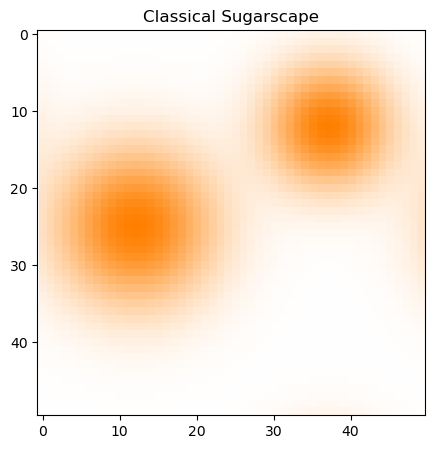

In [108]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.
spot_positions = [(N //4, N // 2), (3 * N // 4, 1 * N // 4), ]  # Center of the sugar spots.
spot_widths = [N / 7, N / 9]  # Width of the sugar spots.
max_sugar = 10  # Maximum sugar level.


SuSca = initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar)
print(SuSca)
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


Defining the polluted areas in the sugarscape

In [ ]:
# Pollution areas
def create_pollution_region(SuSca, N, x_centers_s, y_centers_s):
    X, Y = np.meshgrid(np.arange(N), np.arange(N))
    #x_centers_s = np.array([3*N / 4, 3 * N / 4])

    level_curve = (np.sqrt(2) / 4) * N

    x_center_pol = np.array([np.random.randint(x_centers_s[0]-level_curve, x_centers_s[1]+level_curve)]) 
    y_center_pol = np.array([np.random.randint(y_centers_s[0]-level_curve, y_centers_s[1]+level_curve)]) 

    r_levels_pol = np.array([1]) / 4 * level_curve # Radius sizes for level curves of pollution areas
    #impact_level = ['pollution'] # First implementation just add a string
    #impact_level = np.array([3]) # Higher value --> higher negative impact on mutation rate (i.e visibility, metabolism, velocity, etc goes down in current agent)

    # On the impact level. It would be interesting if we could impact the current generation only, but that the kids of those suffer consequences from their parents, i.e 
    # that the children of agents living close by pollution are worse off economically in this model. The children would be "born" when two agents meet and are of different
    # gender (?). We could maybe even seperate the agents by species, so that we can plot how the economy of each bloodline differs over time
    # in order for the agents not to move away from this, their movement shouldn't be affected by the pollution rate, i.e not to be educated about the hazards of pollution

    #for i in range(np.size(impact_level)):
    d = np.sqrt((X - x_center_pol) ** 2 + (Y - y_center_pol) ** 2)
    region = np.where(d <= r_levels_pol[0])
#        SuSca[region[0], region[1]] = SuSca[region[0], region[1]] + impact_level[i] # Jag vill få varje element här att vara elementet självt plus en tag för pollution

    return region

In [109]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

x_positions = np.random.randint(0, N, A)  # Random X positions
y_positions = np.random.randint(0, N, A)  # Random Y positions

# Create the agents with random integers between 1 and 5
agents = pd.DataFrame({
    "sugar": np.random.randint(3, 6, A),        # Random integers between 1 and 5 for sugar
    "metabolism": np.random.randint(1, 3, A),   # Random integers between 1 and 5 for metabolism
    "vision": np.random.randint(1, 6, A),       # Random integers between 1 and 5 for vision
    "fitness": np.zeros(A),                     # Initialize fitness to 0
    "age" : np.zeros(A),                        # Initialize age to 0
    "lifespan": np.random.randint(20, 50, A),   # Initialize lifespan randomly
    "x": x_positions,                           # X-coordinate of agent
    "y": y_positions                            # Y-coordinate of agent
})



In [ ]:
import time
from tkinter import Tk
from tkinter import Canvas
import numpy as np

r0 = 0.25
N_skip = 1

# Visualize status every N_skip steps. 
window_size = 600

# Define the RGB colors for white and orange
RGB1 = [1.0, 0.5, 0.0]  # Orange for high values.
RGB0 = [1.0, 1.0, 1.0]  # White for low values.

# Normalize sugar array
#normalized_sugar = SuSca / max_sugar  # Normalize to [0, 1]

# Convert the sugar array to RGB colors
#color_image = convert2RGB(SuSca, RGB0, RGB1)

tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
canvas.place(x=10, y=10, height=window_size, width=window_size)

step = 0

def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
running = True  # Flag to control the loop.

while running:

    nSuSca, nA = move_agents(SuSca, agents, N)  # Move the agents on the sugarscape.

    # Update animation frame.
    if step % N_skip == 0:
        canvas.delete('all')
        SU_cells = []
        
         # Normalize sugar array
        #normalized_sugar = nSuSca / max_sugar  # Normalize to [0, 1]
        color_image = convert2RBG(nSuSca, RGB0, RGB1)

        # Use the converted RGB image to draw the cells
        for i in range(N):
            for j in range(N):
                # Get the color from the RGB image
                cell_color = color_image[i, j]
                hex_color = f'#{int(cell_color[0]*255):02x}{int(cell_color[1]*255):02x}{int(cell_color[2]*255):02x}'
                
                SU_cells.append(
                    canvas.create_rectangle(
                        i / N * window_size, 
                        j / N * window_size,
                        (i + 1) / N * window_size,
                        (j + 1) / N * window_size, 
                        outline='', 
                        fill=hex_color,
                    )
                )

        # Update the agents
        Agents_circ = []
        for _, agent in agents.iterrows():  # Iterating through each row in the DataFrame
            x = agent["x"]  # X-coordinate of the agent
            y = agent["y"]  # Y-coordinate of the agent

            # Drawing the agent as a circle
            Agents_circ.append(
                canvas.create_oval(
                    (x + 0.5 - r0) / N * window_size,  # Top-left x-coordinate
                    (y + 0.5 - r0) / N * window_size,  # Top-left y-coordinate
                    (x + 0.5 + r0) / N * window_size,  # Bottom-right x-coordinate
                    (y + 0.5 + r0) / N * window_size,  # Bottom-right y-coordinate
                    outline='', 
                    fill='#000000',
                )
            )

        tk.title(f'Iteration {step}')
        tk.update_idletasks()
        tk.update()
        time.sleep(.1)  # Increase to slow down the simulation.


    # calculate the agents new fitness
    agents['fitness'] = agents.apply(calculate_fitness, axis=1)

    # increase the age of the agents and remove the ones that have lived happily their lifespan.
    agents['age'] += 1
    agents = agents[agents['age'] < agents['lifespan']]


    SuSca = nSuSca
    agents = nA
    step += 1 
    
    # after some steps, apply the GA logic
    if step >20:
        parents = select_parents(agents, 10)
        new_agents = []
        for i in range(0, len(parents), 2):
            parent1 = parents.iloc[i]
            parent2 = parents.iloc[i + 1]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_agents.append(child1)
            new_agents.append(child2)
        agents = replace_population(agents, pd.DataFrame(new_agents))  # Keeping the old agents and adding the new ones to the population --> Population size grows each round
        print(agents)
    
    # Periodically regenerate sugar hotspots
    if step % 13 == 0:  # Regenerate every 20 steps
        SuSca += regenerate_hotspots(SuSca, N=50, num_hotspots=3, max_sugar=10, peak_value=5, sigma=4)

        


tk.update_idletasks()
tk.update()
tk.mainloop()  # Release animation handle (close window to finish).


/var/folders/zq/yh_k39cj0j5_89c5hk05fxf40000gn/T/ipykernel_15348/3322359263.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.762067110250129' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  agents.at[i, "sugar"] += SuSca[new_x, new_y]


       sugar  metabolism  vision  fitness  age  lifespan     x     y
0   4.761637         1.0     4.0      0.0  0.0      35.0  19.0  36.0
1   6.820228         1.0     4.0      0.0  0.0      48.0  15.0  41.0
2   0.701906         1.0     4.0      0.0  0.0      28.0  16.0  37.0
3   5.938543         1.0     3.0      0.0  0.0      45.0  20.0  44.0
4   5.079379         1.0     5.0      0.0  0.0      41.0  18.0  36.0
5   1.053985         1.0     4.0      0.0  0.0      24.0  18.0  44.0
6   4.761637         1.0     4.0      0.0  0.0      35.0  19.0  36.0
7   6.820228         1.0     4.0      0.0  0.0      48.0  15.0  41.0
8   0.701906         1.0     4.0      0.0  0.0      28.0  16.0  37.0
9   5.938543         1.0     3.0      0.0  0.0      45.0  20.0  44.0
10  5.079379         1.0     5.0      0.0  0.0      41.0  18.0  36.0
11  0.701906         1.0     4.0      0.0  0.0      28.0  16.0  37.0
12  6.820228         1.0     4.0      0.0  0.0      48.0  15.0  41.0
13  6.820228         1.0     4.0  

TclError: invalid command name ".!canvas"

: 

In [ ]:
# import time
# from tkinter import Tk, Canvas
# import numpy as np
# import pandas as pd  # Assuming agents are stored in a DataFrame

# # Parameters
# r0 = 0.25
# N_skip = 1
# window_size = 600
# RGB1 = [1.0, 0.5, 0.0]  # Orange for high sugar
# RGB0 = [1.0, 1.0, 1.0]  # White for low sugar

# def convert2RGB(game_outcome, RGB0, RGB1):
#     """
#     Convert the sugar levels into an RGB color map dynamically.
#     """
#     game_outcome -= np.amin(game_outcome)
#     game_outcome /= np.amax(game_outcome)
#     I_RGB = np.zeros((*game_outcome.shape, 3))
#     for c in range(3):
#         I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]
#     return I_RGB

# # Function to dynamically update the canvas
# def update_canvas(canvas, SuSca, agents, SU_cells, Agents_circ, N, window_size):
#     """
#     Update the canvas dynamically for Sugarscape and agents.
#     """
#     # Normalize sugar levels for RGB mapping
#     normalized_sugar = SuSca / np.max(SuSca)
#     color_image = convert2RGB(normalized_sugar, RGB0, RGB1)

#     # Clear old sugar cells
#     for cell in SU_cells:
#         canvas.delete(cell)
#     SU_cells.clear()

#     # Update Sugarscape
#     for i in range(N):
#         for j in range(N):
#             if SuSca[i, j] > 0:
#                 cell_color = color_image[i, j]
#                 hex_color = f'#{int(cell_color[0] * 255):02x}{int(cell_color[1] * 255):02x}{int(cell_color[2] * 255):02x}'
#                 SU_cells.append(
#                     canvas.create_rectangle(
#                         i / N * window_size,
#                         j / N * window_size,
#                         (i + 1) / N * window_size,
#                         (j + 1) / N * window_size,
#                         outline='',
#                         fill=hex_color
#                     )
#                 )

#     # Clear old agent circles
#     for circ in Agents_circ:
#         canvas.delete(circ)
#     Agents_circ.clear()

#     # Update agents
#     for _, agent in agents.iterrows():
#         x, y = agent["x"], agent["y"]
#         Agents_circ.append(
#             canvas.create_oval(
#                 (x + 0.5 - r0) / N * window_size,
#                 (y + 0.5 - r0) / N * window_size,
#                 (x + 0.5 + r0) / N * window_size,
#                 (y + 0.5 + r0) / N * window_size,
#                 outline='',
#                 fill='#000000'
#             )
#         )

# # Initialize Tkinter
# tk = Tk()
# tk.geometry(f'{window_size + 20}x{window_size + 20}')
# tk.configure(background='#000000')

# canvas = Canvas(tk, background='#ECECEC')
# canvas.place(x=10, y=10, height=window_size, width=window_size)

# # Initial state
# step = 0
# running = True
# SU_cells = []
# Agents_circ = []

# # Stop loop on Escape key
# def stop_loop(event):
#     global running
#     running = False
# tk.bind("<Escape>", stop_loop)

# # Animation loop
# while running:
#     # Update Sugarscape and agents
#     nSuSca, nA = move_agents(SuSca, agents, N)

#     if step % N_skip == 0:
#         update_canvas(canvas, SuSca, agents, SU_cells, Agents_circ, N, window_size)
#         tk.title(f'Iteration {step}')
#         tk.update_idletasks()
#         tk.update()
#         time.sleep(0.1)  # Adjust this for speed

#     # Update agents with fitness
#     agents['fitness'] = agents.apply(calculate_fitness, axis=1)

#     # Apply genetic algorithm after some steps
#     if step > 30:
#         parents = select_parents(agents, 10)
#         new_agents = []
#         for i in range(0, len(parents), 2):
#             parent1 = parents.iloc[i]
#             parent2 = parents.iloc[i + 1]
#             child1, child2 = crossover(parent1, parent2)
#             child1 = mutate(child1)
#             child2 = mutate(child2)
#             new_agents.extend([child1, child2])
#         agents = replace_population(agents, pd.DataFrame(new_agents))

#     # Regenerate sugar hotspots periodically
#     if step % 20 == 0:
#         SuSca = regenerate_hotspots(SuSca, N=50, num_hotspots=3, max_sugar=10, peak_value=5, sigma=4)

#     agents = nA
#     step += 1

# # Close Tkinter when finished
# tk.update_idletasks()
# tk.update()
# tk.mainloop()


Now let's try without animation.

In [ ]:
# from random import sample

# N = 50  # Size of the sugarscape with the agents.
# A = 400  # Number of agents on the sugarscape.

# # Initial values. Chosen from the following flat distributions.
# possible_m = np.arange(4) + 1  # Metabolic rate.
# possible_v = np.arange(6) + 1  # Vision.
# possible_s = np.arange(21) + 5  # Sugar.

# # Agents initialized. 
# M = np.random.randint(np.size(possible_m), size=A) + 1
# V = np.random.randint(np.size(possible_v), size=A) + 1
# S = np.random.randint(np.size(possible_s), size=A) + 5

# M0 = M.copy()
# S0 = S.copy()
# V0 = V.copy()

# # Define agents position. 
# L = np.array(sample(range(N * N), A)).astype(int) 
# x = L % N
# y = ((L - x) / N).astype(int) 
# # This way each agent occupy a different cell.

# SuSca = initialize_sugarscape(N)

# # Number of agents
# num_agents = 400

# # Create a DataFrame with random values for each attribute
# agents = pd.DataFrame({
#     "sugar": np.random.uniform(0, 1, num_agents),       # Random sugar values
#     "metabolism": np.random.uniform(0, 1, num_agents), # Random metabolism values
#     "vision": np.random.uniform(0, 1, num_agents),     # Random vision values
#     "fitness": np.zeros(num_agents)                    # Initialize fitness to 0
# })


In [ ]:
# from IPython.display import clear_output
# from matplotlib import pyplot as plt
    
# # Create the image of the game outcome.
# RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
# RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

# MAX_STEP = 1001
# N_skip = 200
# step = 0

# N_alive_agents = np.zeros(MAX_STEP)


# running = True  # Flag to control the loop.
# while running:

#     N_alive_agents[step] = A

#     nSuSca, nA, nV, nS, nM, nx, ny = move_agents(SuSca, A, V, S, M, x, y)

#     if step % N_skip == 0:   
#         SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

#         plt.figure(figsize=(5, 5))
#         plt.imshow(SuSca_RGB)
#         plt.plot(ny, nx, '.', color='k')
#         plt.show()
    
    
#     A = nA
#     V = nV.copy()
#     S = nS.copy()
#     M = nM.copy()
#     x = nx.copy()
#     y = ny.copy()
#     step += 1
    
#     if step >= MAX_STEP:
#         running = False

        
# # Final Values
# M1 = M.copy()
# S1 = S.copy()
# V1 = V.copy()



Compare histograms:

In [ ]:
print(A)

400


#### Metabolism

In [ ]:
# # Metabolism: initial and final distribution.
# m_bins = possible_m
# m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
# m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
# m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


# plt.figure(figsize=(10, 5))
# plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
# plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
# plt.legend()
# plt.xlabel('m')
# plt.title('metabolism')
# plt.show()





#### Vision

In [ ]:
# # Vision: initial and final distribution.
# v_bins = possible_v
# v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
# v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
# v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


# plt.figure(figsize=(10, 5))
# plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
# plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
# plt.legend()
# plt.xlabel('v')
# plt.title('vision')
# plt.show()


#### Sugar

In [ ]:
# # Sugar: initial and final distribution.
# s_bins_i = possible_s
# s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
# s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

# plt.figure(figsize=(10, 5))
# plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
# plt.legend()
# plt.xlabel('s')
# plt.title('sugar')
# plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
# def Lorenz_curve(s):
#     """
#     Function to generate the Lorenz curve from a sequence of data.
    
#     Parameters
#     ==========
#     s : Sugar of each agent.
#     """
    
#     N = np.size(s)
    
#     population_fraction = np.arange(N) / N
    
#     s_sorted = np.sort(s)
    
#     cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
#     return cumulative_s_fraction, population_fraction

In [ ]:
# L0, F0 = Lorenz_curve(S0)


# plt.figure(figsize=(5, 5))
# plt.plot(F0, L0, '.-', label='initial')
# plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
# plt.legend()
# plt.xlabel('F')
# plt.ylabel('L')
# plt.title('sugar')
# plt.show()


